In [ ]:
pip install transformers torch shap spacy datasets

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import shap
import spacy
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

model_name = "textattack/bert-base-uncased-SST-2"
model = AutoModelForSequenceClassification.from_pretrained(model_name, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
# phrase extractor
def extract_phrases(text):
    doc = nlp(text)
    phrases = []

    #  noun chunks
    for np in doc.noun_chunks:
        phrases.append((np.text, np.start, np.end))

    #  verb phrases based on verbs and their children
    for token in doc:
        if token.pos_ == 'VERB':
            start = token.i
            end = token.i + 1
            children = list(token.children)
            if children:
                start = min(start, min(child.i for child in children))
                end = max(end, max(child.i for child in children) + 1)
            phrases.append((doc[start:end].text, start, end))

    #  prepositional phrases
    for token in doc:
        if token.dep_ == 'prep':
            start = token.i
            end = token.i + 1
            children = list(token.children)
            if children:
                start = min(start, min(child.i for child in children))
                end = max(end, max(child.i for child in children) + 1)
            phrases.append((doc[start:end].text, start, end))

    #  adjective phrases
    for token in doc:
        if token.pos_ == 'ADJ':
            start = token.i
            end = token.i + 1
            children = list(token.children)
            if children:
                start = min(start, min(child.i for child in children))
                end = max(end, max(child.i for child in children) + 1)
            phrases.append((doc[start:end].text, start, end))

    # Remove duplicates and sort by start index
    unique_phrases = []
    seen = set()
    for phrase in sorted(phrases, key=lambda x: x[1]):
        if phrase not in seen:
            unique_phrases.append(phrase)
            seen.add(phrase)

    return unique_phrases




In [ ]:
# Function to mask phrases
def custom_phrase_masker(mask, input_ids_np, phrases):
    input_ids = torch.tensor(input_ids_np, dtype=torch.long)
    mask = torch.tensor(mask, dtype=torch.long)

    if input_ids.ndimension() == 1:
        input_ids = input_ids.unsqueeze(0)
    if mask.ndimension() == 1:
        mask = mask.unsqueeze(0)

    masked_input_ids = input_ids.clone()
    for phrase, start, end in phrases:
        if mask[0, start:end].sum() == 0:
            masked_input_ids[0, start:end] = tokenizer.pad_token_id

    return masked_input_ids.numpy()

In [ ]:
# Function to explain using model encoder layers
def model_encoder_layer_explainer(masked_input_ids_np, layer_idx, embedding):
    masked_input_ids = torch.tensor(masked_input_ids_np, dtype=torch.long)
    if masked_input_ids.ndimension() == 1:
        masked_input_ids = masked_input_ids.unsqueeze(0)

    with torch.no_grad():
        embeddings = embedding(masked_input_ids)
        outputs = model(inputs_embeds=embeddings, output_hidden_states=True)
    hidden_state = outputs.hidden_states[layer_idx]
    logits = model.classifier(hidden_state.mean(dim=1))
    probs = torch.softmax(logits, dim=1)

    return probs.detach().numpy()

In [ ]:
# Function to explain using embedding layer
def embedding_layer_explainer(masked_input_ids_np):
    masked_input_ids = torch.tensor(masked_input_ids_np, dtype=torch.long)
    if masked_input_ids.ndimension() == 1:
        masked_input_ids = masked_input_ids.unsqueeze(0)

    with torch.no_grad():
        outputs = model(masked_input_ids, output_hidden_states=True)
    hidden_state = outputs.hidden_states[0]
    logits = model.classifier(hidden_state.mean(dim=1))
    probs = torch.softmax(logits, dim=1)

    return probs.detach().numpy()


In [ ]:
# Function to explain using attention layer
def attention_layer_explainer(embedding,input_ids):

    with torch.no_grad():
        embeddings = embedding(input_ids)
        outputs = model(inputs_embeds=embeddings,output_hidden_states=True, output_attentions=True)
        attentions = outputs.attentions

    return attentions


In [ ]:
# Aggregate attention scores across phrases
def aggregate_attention_scores(attentions, phrases):
    attention_per_phrase = {layer_idx: [] for layer_idx in range(len(attentions))}

    # Iterate over all layers
    for layer_idx, layer_attention in enumerate(attentions):
        layer_attention = layer_attention.mean(dim=1)  # Average over attention heads [batch_size, seq_len, seq_len]

        # Normalize the attention scores over the sequence length
        norm_attention = torch.nn.functional.softmax(layer_attention[0], dim=-1)  # Apply softmax to normalize

        for phrase, start, end in phrases:
            # Sum the normalized attention for the given phrase
            phrase_attention = torch.mean(norm_attention[start:end, :]).item()
            attention_per_phrase[layer_idx].append({
                'phrase': phrase,
                'attention_score': phrase_attention
            })

    return attention_per_phrase


In [ ]:
# Function to explain using decoder layer (if applicable)
def decoder_explainer(masked_input_ids_np, encoder_hidden_states):
    masked_input_ids = torch.tensor(masked_input_ids_np, dtype=torch.long)
    if masked_input_ids.ndimension() == 1:
        masked_input_ids = masked_input_ids.unsqueeze(0)

    decoder_input_ids = torch.tensor([[model.config.pad_token_id]])

    with torch.no_grad():
        decoder_outputs = model.decoder(input_ids=decoder_input_ids, encoder_hidden_states=encoder_hidden_states)
        decoder_hidden_states = decoder_outputs.last_hidden_state
        logits = model.lm_head(decoder_hidden_states)
        probs = torch.softmax(logits, dim=1)

    return probs.detach().numpy()

In [ ]:
def plot_shap_values(shap_values_per_phrase, filename, title):
    num_classes = len(shap_values_per_phrase)

    plt.figure(figsize=(15, 6 * num_classes))

    for class_idx in range(num_classes):

        class_shap_values = [entry['shap_value'] for entry in shap_values_per_phrase[class_idx]]
        phrases_text = [entry['phrase'] for entry in shap_values_per_phrase[class_idx]]

        plt.subplot(num_classes, 1, class_idx + 1)

        colors = ['green' if val > 0 else 'red' for val in class_shap_values]

        plt.bar(range(len(class_shap_values)), class_shap_values, color=colors)
        plt.xticks(range(len(phrases_text)), phrases_text, rotation=45, ha='right')
        plt.xlabel('Phrase')
        plt.ylabel('SHAP Value')
        plt.title(f'{title} - Class {"Positive" if class_idx == 0 else "Negative"}')
        plt.axhline(0, color='black', linewidth=0.5)

    plt.tight_layout()
    plt.savefig(filename, format='png', bbox_inches='tight')
    plt.show()


In [ ]:
# Define a custom masker function for SHAP
def masker(mask, input_ids_np):
    return custom_phrase_masker(mask, input_ids_np, phrases)

In [ ]:
def update_phrase_index(phrases):

    tokens = tokenizer.tokenize(text)

    updated_phrases = []

    for phrase, original_start, original_end in phrases:
        word_tokens = tokenizer.tokenize(phrase)
        start = None
        end = None

        # Find the start and end indices in the tokenized text
        for idx in range(len(tokens) - len(word_tokens) + 1):
            if tokens[idx:idx + len(word_tokens)] == word_tokens:
                start = idx+1
                end = idx + len(word_tokens)+1
                break

        if start is not None and end is not None:
            updated_phrases.append((phrase, start, end))
        else:
            print(f"Phrase '{phrase}' not found in the tokenized text.")

    return updated_phrases

In [ ]:
def extract_shap_values(shap_values, phrases):
    shap_values_array = shap_values.values.squeeze()

    shap_values_per_phrase = {class_idx: [] for class_idx in range(shap_values_array.shape[1])}

    for class_idx in range(shap_values_array.shape[1]):

        shap_values_per_token = shap_values_array[:, class_idx]

        for phrase, start, end in phrases:

            phrase_shap_value = np.sum(shap_values_per_token[start:end])

            shap_values_per_phrase[class_idx].append({
                'phrase': phrase,
                'start': start,
                'end': end,
                'shap_value': phrase_shap_value
            })

            #print(f"Class {class_idx} - Phrase: '{phrase}', Start: {start}, End: {end}")
            #print("SHAP value for this phrase:")
            #print(phrase_shap_value)
    #print(shap_values_per_phrase)
    return shap_values_per_phrase


In [ ]:
def plot_attention_values_all_layers(attention_per_phrase, filename, title):
    num_layers = len(attention_per_phrase)
    plt.figure(figsize=(15, 6 * num_layers))

    for layer_idx in range(num_layers):
        phrases_text = [entry['phrase'] for entry in attention_per_phrase[layer_idx]]
        attention_scores = [entry['attention_score'] for entry in attention_per_phrase[layer_idx]]
        plt.subplot(num_layers, 1, layer_idx + 1)
        colors = ['blue' for _ in attention_scores]
        plt.bar(range(len(attention_scores)), attention_scores, color=colors)
        plt.xticks(range(len(phrases_text)), phrases_text, rotation=45, ha='right')
        plt.xlabel('Phrase')
        plt.ylabel('Attention Score')
        plt.title(f'{title} - Attention Layer {layer_idx}')
        plt.axhline(0, color='black', linewidth=0.5)

    plt.tight_layout()
    plt.savefig(filename, format='png', bbox_inches='tight')
    plt.show()

In [ ]:

# Load the SST-2 dataset
dataset = load_dataset('glue', 'sst2', split='validation')

# Select a sample text from the dataset
sample_index = 101  # Change this index to use a different sample
text = dataset[sample_index]['sentence']
label = dataset[sample_index]['label']

print(f"Sample Text: {text}")
print(f"True Label: {'Positive' if label == 1 else 'Negative'}")

inputs = tokenizer(text, return_tensors="pt")

phrases = extract_phrases(text)
phrases=update_phrase_index(phrases)
print(phrases)
input_ids = inputs['input_ids']
embedding_layer = model.get_input_embeddings()

README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Sample Text: his last movie was poetically romantic and full of indelible images , but his latest has nothing going for it . 
True Label: Negative
[('his last movie', 1, 4), ('last', 2, 3), ('romantic and full', 7, 10), ('full of', 9, 11), ('of indelible images', 10, 15), ('indelible images', 11, 15), ('indelible', 11, 14), ('his latest', 17, 19), ('latest has nothing going for it .', 18, 25), ('nothing', 20, 21), ('nothing going for', 20, 23), ('for it', 22, 24), ('it', 23, 24)]


In [ ]:
# SHAP Explainers
encoder_explainer = shap.Explainer(lambda x: model_encoder_layer_explainer(x, 12, embedding_layer), masker, input_shape=(input_ids.shape))
encoder_shap_values = encoder_explainer(input_ids.numpy())

embedding_explainer = shap.Explainer(lambda x: embedding_layer_explainer(x), masker, input_shape=(input_ids.shape))
embedding_shap_values = embedding_explainer(input_ids.numpy())

attentions = attention_layer_explainer(embedding_layer, input_ids)


#decoder_explainer = shap.Explainer(decoder_explainer, masker)
#decoder_shap_values = decoder_explainer(input_ids.numpy())

PermutationExplainer explainer: 2it [00:51, 51.81s/it]               
PermutationExplainer explainer: 2it [00:44, 44.25s/it]               
BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [ ]:
print(encoder_shap_values.values)

[[[-4.96705373e-09  8.27842289e-09]
  [ 5.90130852e-03 -5.90130024e-03]
  [ 1.74684409e-02 -1.74684475e-02]
  [ 9.96463829e-03 -9.96462835e-03]
  [-6.62273831e-09  0.00000000e+00]
  [-1.15897920e-08 -9.93410746e-09]
  [-1.65568458e-09  0.00000000e+00]
  [ 4.37754889e-03 -4.37757373e-03]
  [ 7.49760866e-03 -7.49762191e-03]
  [ 1.50592708e-02 -1.50592774e-02]
  [ 6.46847818e-04 -6.46851129e-04]
  [-1.59519249e-03  1.59521898e-03]
  [-3.69710558e-03  3.69713207e-03]
  [-2.41123140e-03  2.41123305e-03]
  [-4.45766581e-04  4.45746713e-04]
  [-1.65568458e-09 -1.65568458e-09]
  [ 8.27842289e-09  4.96705373e-09]
  [ 1.13865369e-02 -1.13865336e-02]
  [ 1.16746790e-02 -1.16746922e-02]
  [ 1.05364786e-03 -1.05364290e-03]
  [-1.11938119e-02  1.11938516e-02]
  [-4.60937785e-03  4.60935301e-03]
  [ 1.52276953e-03 -1.52276622e-03]
  [ 8.50519869e-03 -8.50517717e-03]
  [-8.39268168e-04  8.39276446e-04]
  [ 0.00000000e+00  4.96705373e-09]]]


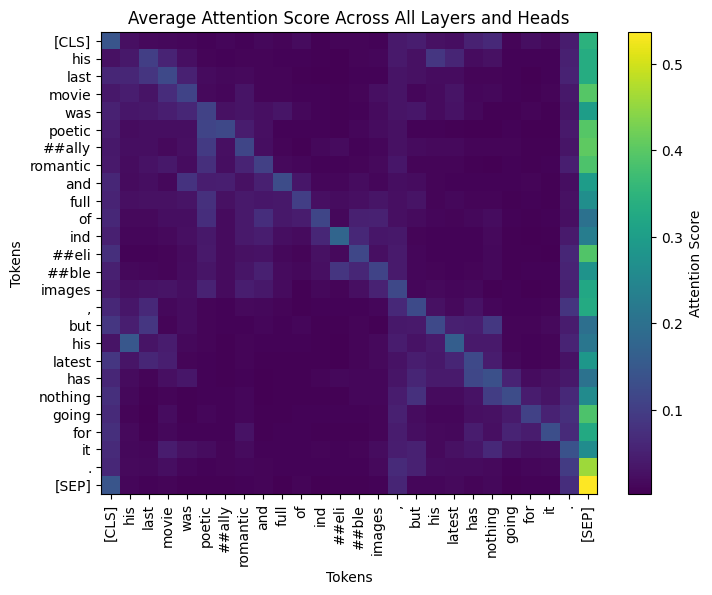

In [ ]:
# Attention weights
attention_weights = attention_layer_explainer(embedding_layer,input_ids)
attention_np = [attn.detach().numpy() for attn in attention_weights]

average_attention = np.mean(np.stack(attention_np), axis=(0, 1))

average_attention = average_attention[0]


tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

plt.figure(figsize=(8, 6))
plt.title("Average Attention Score Across All Layers and Heads")

plt.imshow(average_attention, cmap='viridis', interpolation='nearest', aspect='auto')
plt.colorbar(label='Attention Score')

plt.xticks(ticks=np.arange(len(tokens)), labels=tokens, rotation=90)
plt.yticks(ticks=np.arange(len(tokens)), labels=tokens)
plt.xlabel("Tokens")
plt.ylabel("Tokens")

plt.show()


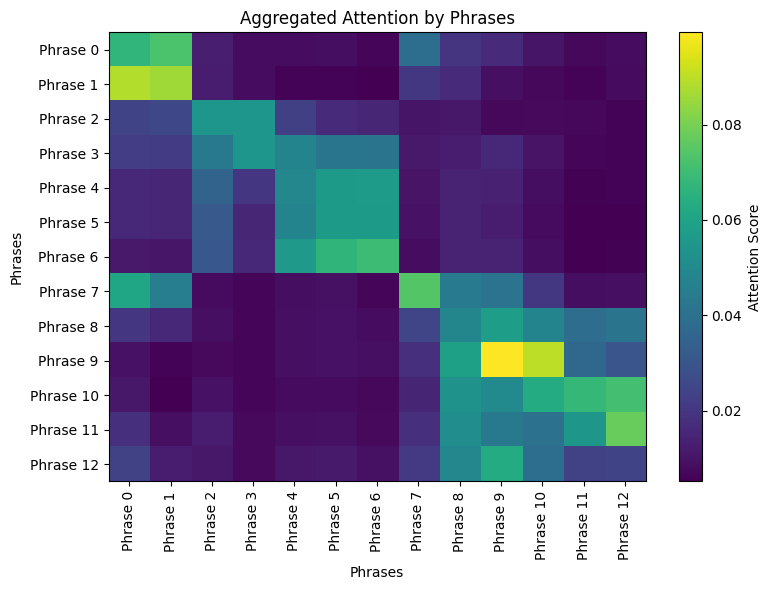

Phrase Index Mapping:
Phrase 0: his last movie
Phrase 1: last
Phrase 2: romantic and full
Phrase 3: full of
Phrase 4: of indelible images
Phrase 5: indelible images
Phrase 6: indelible
Phrase 7: his latest
Phrase 8: latest has nothing going for it .
Phrase 9: nothing
Phrase 10: nothing going for
Phrase 11: for it
Phrase 12: it


In [ ]:
# Aggregate attention by phrases
def aggregate_attention_by_phrase(average_attention, phrases):
    aggregated_attention = np.zeros((len(phrases), len(phrases)))

    for i, (phrase_i, start_i, end_i) in enumerate(phrases):
        for j, (phrase_j, start_j, end_j) in enumerate(phrases):
            # Average attention over tokens in both phrases
            aggregated_attention[i, j] = np.mean(average_attention[start_i:end_i, start_j:end_j])

    return aggregated_attention

# Aggregate the attention for phrases
phrase_attention = aggregate_attention_by_phrase(average_attention, phrases)
# Assign index numbers to the phrases
phrase_index = {i: phrase[0] for i, phrase in enumerate(phrases)}

# Create phrase labels using indices
phrase_labels_indexed = [f"Phrase {i}" for i in phrase_index]

# Plot the aggregated attention matrix with indices as labels
plt.figure(figsize=(8, 6))
plt.title("Aggregated Attention by Phrases")

plt.imshow(phrase_attention, cmap='viridis', interpolation='nearest', aspect='auto')
plt.colorbar(label='Attention Score')

# Apply index labels to axes
plt.xticks(ticks=np.arange(len(phrase_labels_indexed)), labels=phrase_labels_indexed, rotation=90)
plt.yticks(ticks=np.arange(len(phrase_labels_indexed)), labels=phrase_labels_indexed)
plt.xlabel("Phrases")
plt.ylabel("Phrases")

plt.tight_layout()
plt.show()

# Display the mapping of indices to full phrases
print("Phrase Index Mapping:")
for i, phrase in phrase_index.items():
    print(f"Phrase {i}: {phrase}")



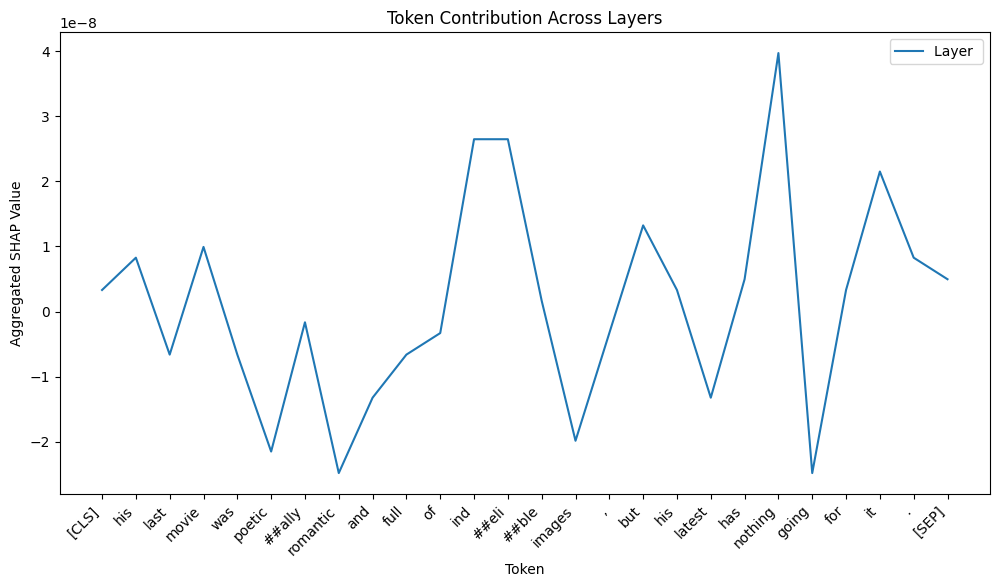

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
encoder_shap_values_array = encoder_shap_values.values.squeeze()
encoder_shap_values_per_token = np.sum(encoder_shap_values_array, axis=1)


# Plot comparison across layers
plt.figure(figsize=(12, 6))
tokens = tokenizer.convert_ids_to_tokens(encoder_shap_values.data[0])

plt.plot(range(len(encoder_shap_values_per_token)), encoder_shap_values_per_token,
             label=f'Layer ')
plt.xticks(range(len(tokens)), tokens, rotation=45, ha='right')
plt.xlabel('Token')
plt.ylabel('Aggregated SHAP Value')
plt.title('Token Contribution Across Layers')
plt.legend()
plt.show()

In [ ]:
# Aggregated SHAP values
encoder_shap_values_per_phrase = extract_shap_values(encoder_shap_values, phrases)
embedding_shap_values_per_phrase = extract_shap_values(embedding_shap_values, phrases)
#attention_shap_values_per_phrase = extract_shap_values(attention_shap_values, phrases)

In [ ]:
print(encoder_shap_values_per_phrase)

{0: [{'phrase': 'his last movie', 'start': 1, 'end': 4, 'shap_value': 0.03333438767327203}, {'phrase': 'last', 'start': 2, 'end': 3, 'shap_value': 0.017468440863821242}, {'phrase': 'romantic and full', 'start': 7, 'end': 10, 'shap_value': 0.02693442834748162}, {'phrase': 'full of', 'start': 9, 'end': 11, 'shap_value': 0.015706118610170152}, {'phrase': 'of indelible images', 'start': 10, 'end': 15, 'shap_value': -0.007502448227670457}, {'phrase': 'indelible images', 'start': 11, 'end': 15, 'shap_value': -0.008149296045303345}, {'phrase': 'indelible', 'start': 11, 'end': 14, 'shap_value': -0.007703529463873969}, {'phrase': 'his latest', 'start': 17, 'end': 19, 'shap_value': 0.02306121587753296}, {'phrase': 'latest has nothing going for it .', 'start': 18, 'end': 25, 'shap_value': 0.006113837162653606}, {'phrase': 'nothing', 'start': 20, 'end': 21, 'shap_value': -0.011193811893463135}, {'phrase': 'nothing going for', 'start': 20, 'end': 23, 'shap_value': -0.014280420210626388}, {'phrase':

In [ ]:
print(embedding_shap_values_per_phrase)

{0: [{'phrase': 'his last movie', 'start': 1, 'end': 4, 'shap_value': 0.0031720184617572353}, {'phrase': 'last', 'start': 2, 'end': 3, 'shap_value': 0.006632198890050252}, {'phrase': 'romantic and full', 'start': 7, 'end': 10, 'shap_value': 0.011375251743528578}, {'phrase': 'full of', 'start': 9, 'end': 11, 'shap_value': 0.007311738199657865}, {'phrase': 'of indelible images', 'start': 10, 'end': 15, 'shap_value': 0.005876004695892334}, {'phrase': 'indelible images', 'start': 11, 'end': 15, 'shap_value': 0.004888239834043715}, {'phrase': 'indelible', 'start': 11, 'end': 14, 'shap_value': 0.0048074639505810216}, {'phrase': 'his latest', 'start': 17, 'end': 19, 'shap_value': 0.002435283528433906}, {'phrase': 'latest has nothing going for it .', 'start': 18, 'end': 25, 'shap_value': 0.022551372647285458}, {'phrase': 'nothing', 'start': 20, 'end': 21, 'shap_value': 0.006225158770879109}, {'phrase': 'nothing going for', 'start': 20, 'end': 23, 'shap_value': 0.008740915192498101}, {'phrase':

['his last movie', 'last', 'romantic and full', 'full of', 'of indelible images', 'indelible images', 'indelible', 'his latest', 'latest has nothing going for it .', 'nothing', 'nothing going for', 'for it', 'it']


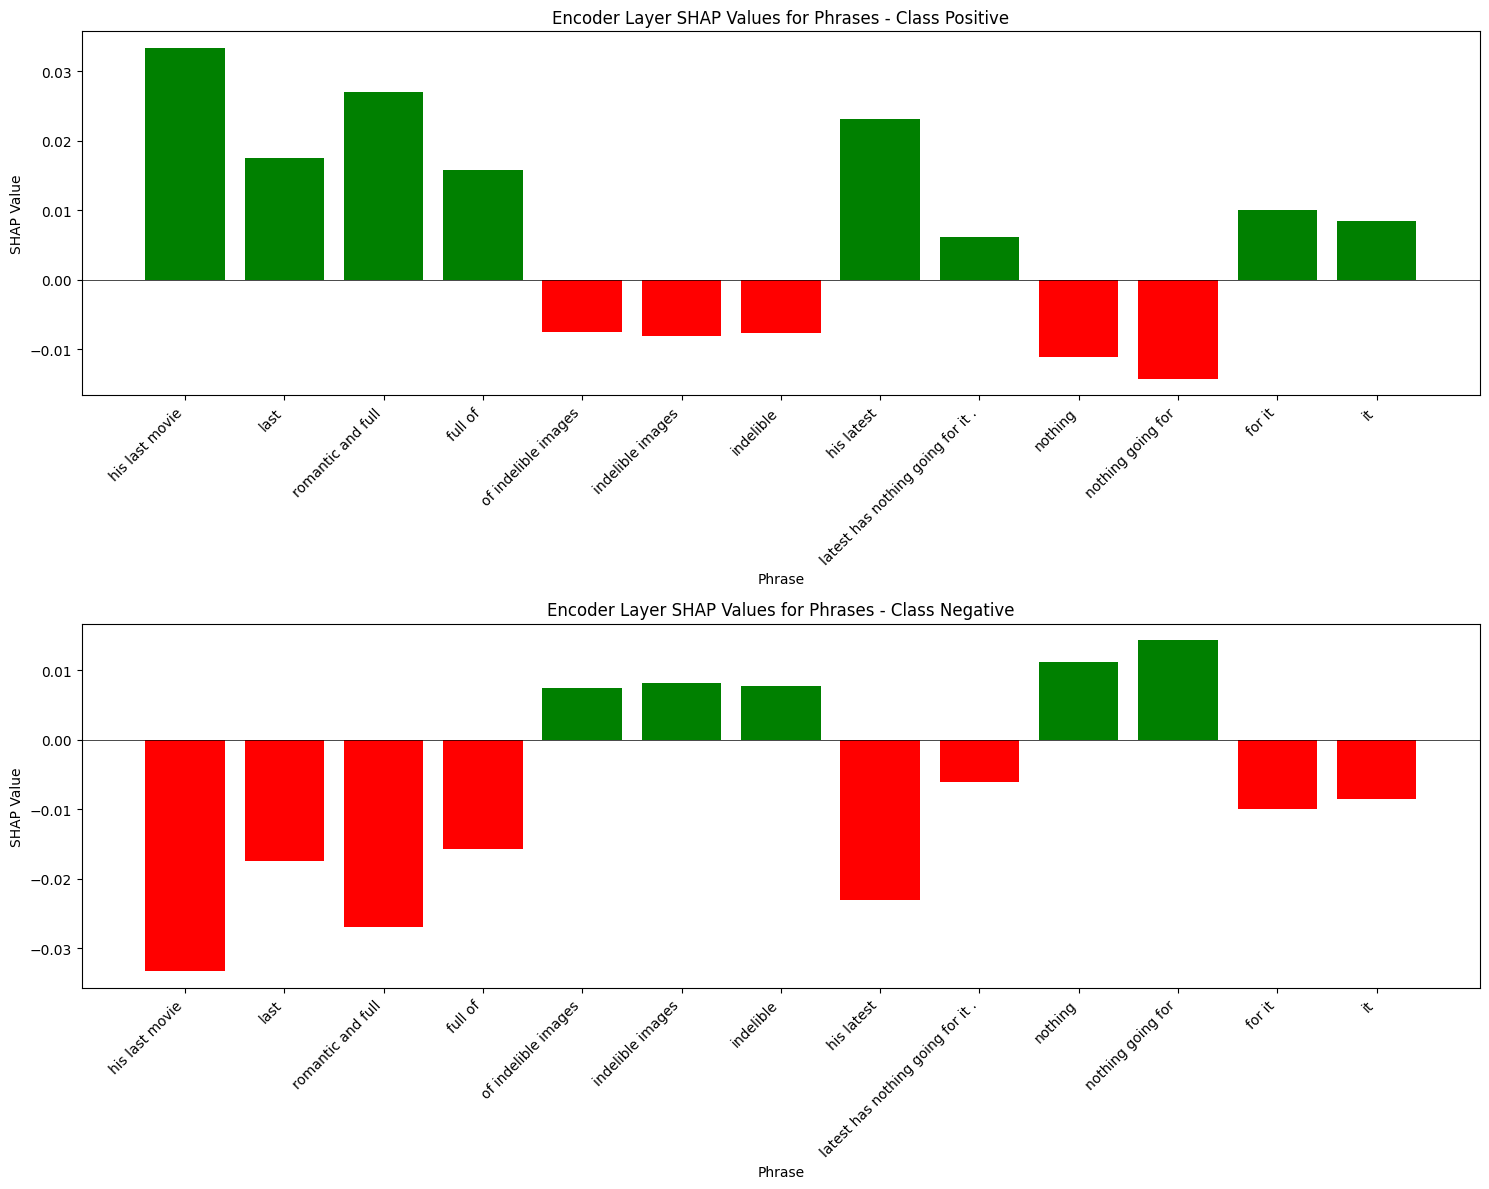

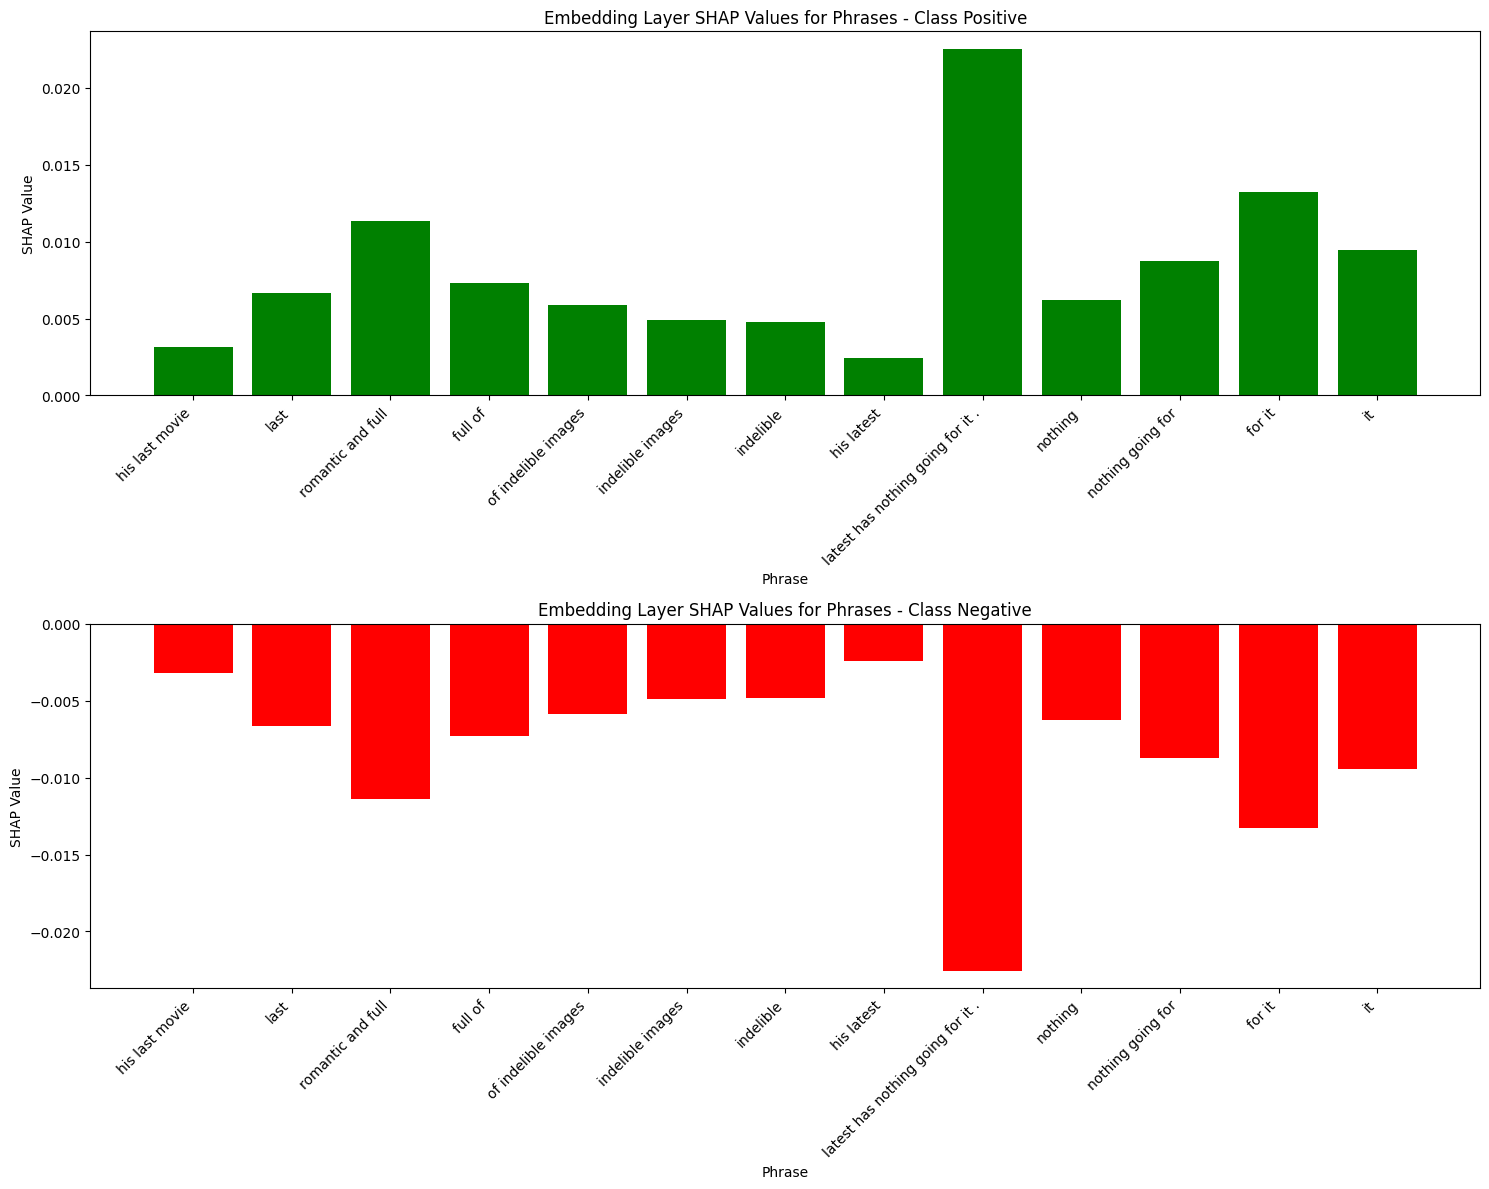

In [ ]:
# Plot aggregated SHAP values
print([phrase[0] for phrase in phrases])
plot_shap_values(encoder_shap_values_per_phrase, 'shap_values_encoder.png', 'Encoder Layer SHAP Values for Phrases')
plot_shap_values(embedding_shap_values_per_phrase,  'shap_values_embedding.png', 'Embedding Layer SHAP Values for Phrases')
#plot_shap_values(attention_shap_values_per_phrase, [phrase[0] for phrase in phrases], 'shap_values_attention.png', 'Attention Layer SHAP Values for Phrases')
#plot_shap_values(decoder_shap_values, [phrase[0] for phrase in phrases], 'shap_values_embedding.png', 'Embedding Layer SHAP Values for Phrases')


In [ ]:
print(encoder_shap_values_per_phrase)
print(embedding_shap_values_per_phrase)
#print(attention_shap_values_per_phrase)

{0: [{'phrase': 'his last movie', 'start': 1, 'end': 4, 'shap_value': 0.03333438767327203}, {'phrase': 'last', 'start': 2, 'end': 3, 'shap_value': 0.017468440863821242}, {'phrase': 'romantic and full', 'start': 7, 'end': 10, 'shap_value': 0.02693442834748162}, {'phrase': 'full of', 'start': 9, 'end': 11, 'shap_value': 0.015706118610170152}, {'phrase': 'of indelible images', 'start': 10, 'end': 15, 'shap_value': -0.007502448227670457}, {'phrase': 'indelible images', 'start': 11, 'end': 15, 'shap_value': -0.008149296045303345}, {'phrase': 'indelible', 'start': 11, 'end': 14, 'shap_value': -0.007703529463873969}, {'phrase': 'his latest', 'start': 17, 'end': 19, 'shap_value': 0.02306121587753296}, {'phrase': 'latest has nothing going for it .', 'start': 18, 'end': 25, 'shap_value': 0.006113837162653606}, {'phrase': 'nothing', 'start': 20, 'end': 21, 'shap_value': -0.011193811893463135}, {'phrase': 'nothing going for', 'start': 20, 'end': 23, 'shap_value': -0.014280420210626388}, {'phrase':

In [ ]:
def concatenate_shap_values(*shap_values_per_layer):
    combined_shap_values = {class_idx: [] for class_idx in range(len(shap_values_per_layer[0]))}

    for class_idx in range(len(shap_values_per_layer[0])):
        for phrase_data in shap_values_per_layer[0][class_idx]:
            phrase = phrase_data['phrase']
            start = phrase_data['start']
            end = phrase_data['end']
            combined_value = sum(layer_data[class_idx][i]['shap_value'] for layer_data in shap_values_per_layer for i in range(len(layer_data[class_idx])) if layer_data[class_idx][i]['phrase'] == phrase and layer_data[class_idx][i]['start'] == start and layer_data[class_idx][i]['end'] == end)
            combined_shap_values[class_idx].append({
                'phrase': phrase,
                'start': start,
                'end': end,
                'shap_value': combined_value
            })

    return combined_shap_values

# Combine SHAP values from different layers
combined_shap_values_per_phrase = concatenate_shap_values(
    encoder_shap_values_per_phrase,
    embedding_shap_values_per_phrase,
   # decoder_shap_values_per_phrase
)


In [ ]:
print(combined_shap_values_per_phrase)

{0: [{'phrase': 'his last movie', 'start': 1, 'end': 4, 'shap_value': 0.036506406135029264}, {'phrase': 'last', 'start': 2, 'end': 3, 'shap_value': 0.024100639753871493}, {'phrase': 'romantic and full', 'start': 7, 'end': 10, 'shap_value': 0.0383096800910102}, {'phrase': 'full of', 'start': 9, 'end': 11, 'shap_value': 0.023017856809828017}, {'phrase': 'of indelible images', 'start': 10, 'end': 15, 'shap_value': -0.0016264435317781233}, {'phrase': 'indelible images', 'start': 11, 'end': 15, 'shap_value': -0.0032610562112596296}, {'phrase': 'indelible', 'start': 11, 'end': 14, 'shap_value': -0.002896065513292948}, {'phrase': 'his latest', 'start': 17, 'end': 19, 'shap_value': 0.025496499405966863}, {'phrase': 'latest has nothing going for it .', 'start': 18, 'end': 25, 'shap_value': 0.028665209809939064}, {'phrase': 'nothing', 'start': 20, 'end': 21, 'shap_value': -0.004968653122584025}, {'phrase': 'nothing going for', 'start': 20, 'end': 23, 'shap_value': -0.005539505018128287}, {'phras

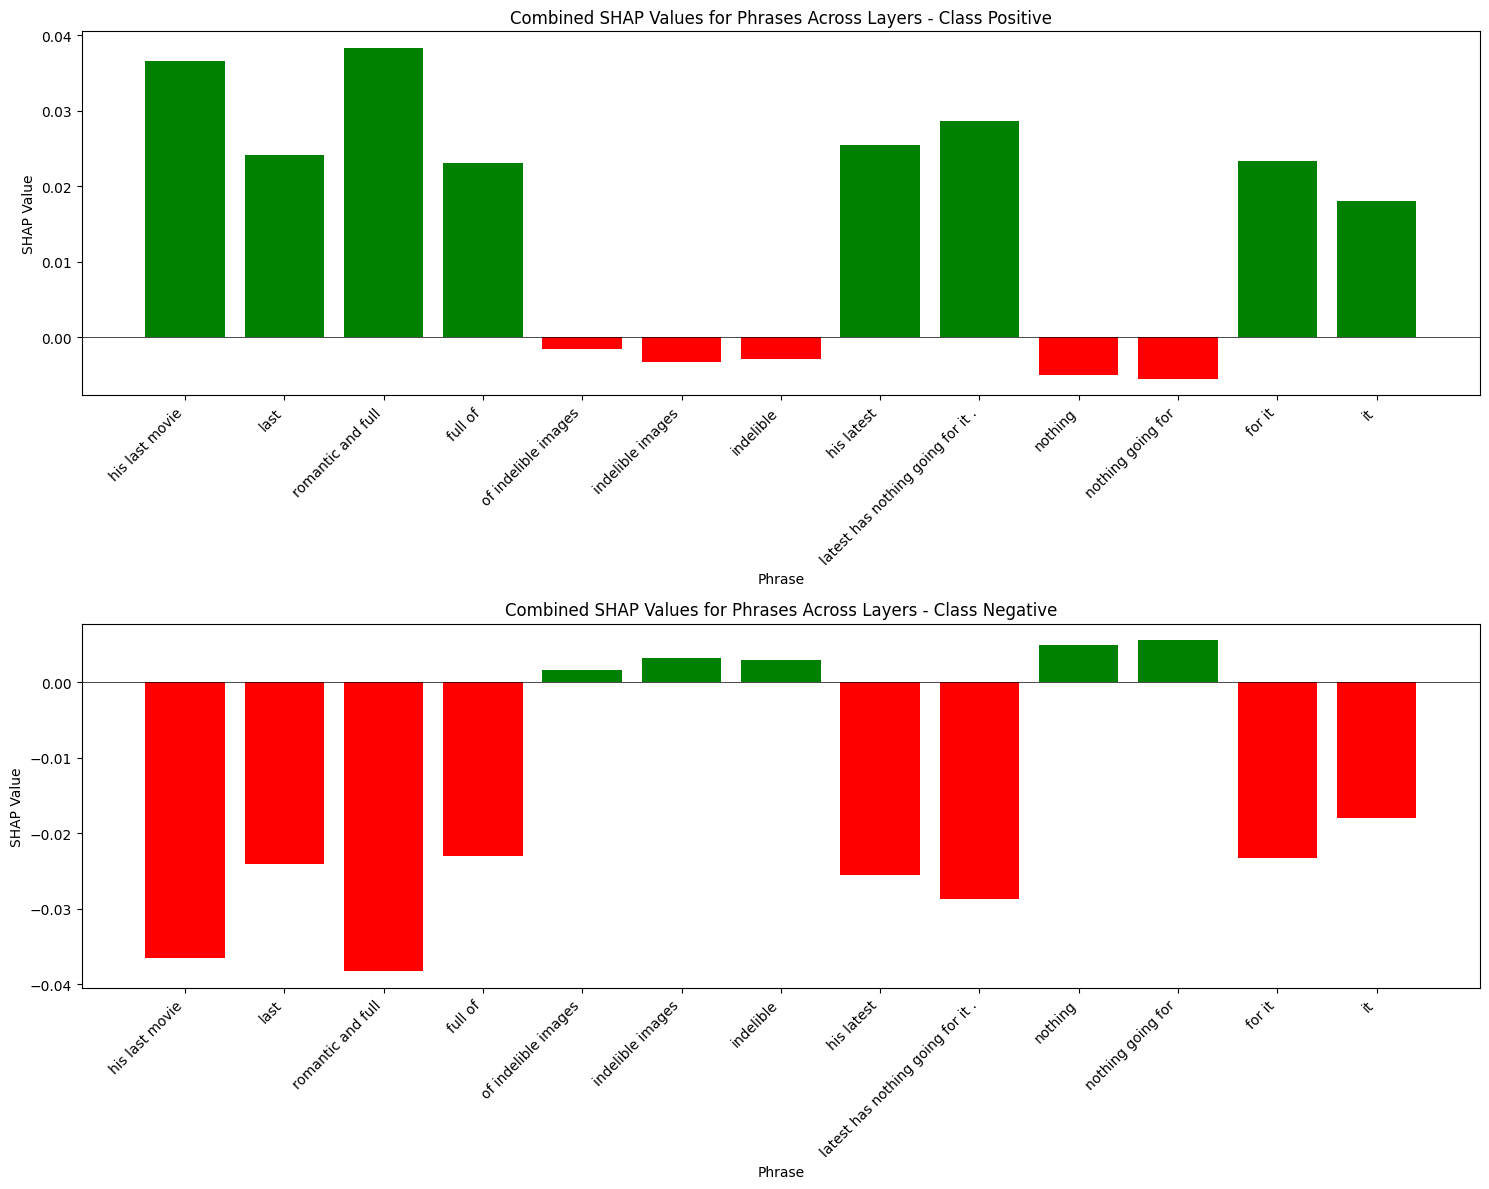

In [ ]:
def plot_combined_shap_values(combined_shap_values_per_phrase, filename, title):
    num_classes = len(combined_shap_values_per_phrase)

    plt.figure(figsize=(15, 6 * num_classes))

    for class_idx in range(num_classes):

        class_shap_values = [entry['shap_value'] for entry in combined_shap_values_per_phrase[class_idx]]
        phrases_text = [entry['phrase'] for entry in combined_shap_values_per_phrase[class_idx]]

        plt.subplot(num_classes, 1, class_idx + 1)

        colors = ['green' if val > 0 else 'red' for val in class_shap_values]

        plt.bar(range(len(class_shap_values)), class_shap_values, color=colors)
        plt.xticks(range(len(phrases_text)), phrases_text, rotation=45, ha='right')
        plt.xlabel('Phrase')
        plt.ylabel('SHAP Value')
        plt.title(f'{title} - Class {"Positive" if class_idx == 0 else "Negative"}')
        plt.axhline(0, color='black', linewidth=0.5)

    plt.tight_layout()
    plt.savefig(filename, format='png', bbox_inches='tight')
    plt.show()


# Plot combined SHAP values
plot_combined_shap_values(combined_shap_values_per_phrase, 'combined_shap_values.png', 'Combined SHAP Values for Phrases Across Layers')
